## Convolutional neural network

Finally, implement a ConvNet **using the matrix of pixels** in a "Convolutional neural network.ipynb" notebook.

**Network architecture:** You can use your own preferred architecture or implement the one that we saw in the exercises. In any case, your network should certain at least one convolutional, one pooling and one fully-connected layer.

In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random

%matplotlib inline

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())

#let's take a look at the keys
print('Data loaded')
print('It is a dictionary with keys:', list(cifar4.keys()))

Data loaded
It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Create X/y arrays
X = cifar4['pixels'].astype(np.float32) #Convert pixels into floating point numbers
y = cifar4['labels']

# Rescale pixel values between -0.5 and 0.5
X = (X - 128) / 255

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)

X: (5000, 3072) float32
y: (5000,) int64


**Q:** Split the data points into train/validation/test sets as previous sections.

In [3]:
# Create train and test set
X_tr, X_te, y_tr, y_te = train_test_split(
    # Reshape images: 32 by 32 with 3 (RGB) color channels
    X.reshape(-1, 32, 32, 3),y,
    train_size=4000, test_size=1000, stratify = y, random_state=0)

In [4]:
#let's make sure of the uniform distribution of the data in the train set
pd.value_counts(y_tr, normalize = 'True')

3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64

In [5]:
# Create validation set
X_trval, X_val, y_trval, y_val = train_test_split(
    X_tr, y_tr, train_size=3200, test_size=800, stratify = y_tr, random_state=0)

In [6]:
#let's make sure of the uniform distribution of the data in the validation set
pd.value_counts(y_val, normalize = 'True')

3    0.25
2    0.25
1    0.25
0    0.25
dtype: float64

**Q:** Train the network using small random batches, and plot its accuracy on the validation set. Finally, evaluate and print the accuracy of your tuned network on the test set.

In [7]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [8]:
# Create new graph
graph = tf.Graph()

with graph.as_default():
    
    training = tf.placeholder(dtype = tf.bool) # Create training placeholder
    
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # Convolutional layer (64 filters, 5x5, stride: 2)
    conv1 = tf.layers.conv2d(
        X, 64, (5, 5), (2, 2), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv1'
    )
    print('Convolutional layer:', conv1.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool1.shape)
    
    # Convolutional layer (64 filters, 3x3, stride: 1)
    conv2 = tf.layers.conv2d(
        pool1, 64, (3, 3), (1, 1), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv2'
    )
    print('Convolutional layer:', conv2.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool2.shape)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    print('Flatten:', flat_output.shape)
    
    # Dropout
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)
    
    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 64, # 64 hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name = 'hidden'
    )
    print('Fully-connected layer:', fc1.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc1, 4, # One output unit per category
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name = 'output'
    )
    print('Output layer:', logits.shape)
    
    # Kernel of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
        
    # Loss fuction: mean cross-entropy with L2 regularization
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Convolutional layer: (?, 16, 16, 64)
Maxpool: (?, 8, 8, 64)
Convolutional layer: (?, 8, 8, 64)
Maxpool: (?, 4, 4, 64)
Flatten: (?, 1024)
Dropout: (?, 1024)
Fully-connected layer: (?, 64)
Output layer: (?, 4)


In [9]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(56): #from the multilayer network
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_trval, y_trval, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_val,
            y: y_val,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
        training: False
        })
    print('Convolutional network accuracy (test set): {:.3f}'.format(test_acc))

Epoch 1 - valid: 0.500 train: 0.418 (mean)
Epoch 2 - valid: 0.559 train: 0.531 (mean)
Epoch 3 - valid: 0.601 train: 0.567 (mean)
Epoch 4 - valid: 0.601 train: 0.598 (mean)
Epoch 5 - valid: 0.626 train: 0.624 (mean)
Epoch 6 - valid: 0.645 train: 0.658 (mean)
Epoch 7 - valid: 0.670 train: 0.683 (mean)
Epoch 8 - valid: 0.694 train: 0.692 (mean)
Epoch 9 - valid: 0.721 train: 0.710 (mean)
Epoch 10 - valid: 0.704 train: 0.730 (mean)
Epoch 11 - valid: 0.739 train: 0.753 (mean)
Epoch 12 - valid: 0.733 train: 0.746 (mean)
Epoch 13 - valid: 0.751 train: 0.758 (mean)
Epoch 14 - valid: 0.725 train: 0.775 (mean)
Epoch 15 - valid: 0.730 train: 0.785 (mean)
Epoch 16 - valid: 0.749 train: 0.796 (mean)
Epoch 17 - valid: 0.746 train: 0.813 (mean)
Epoch 18 - valid: 0.761 train: 0.821 (mean)
Epoch 19 - valid: 0.772 train: 0.814 (mean)
Epoch 20 - valid: 0.770 train: 0.828 (mean)
Epoch 21 - valid: 0.767 train: 0.828 (mean)
Epoch 22 - valid: 0.776 train: 0.843 (mean)
Epoch 23 - valid: 0.799 train: 0.847 (mea

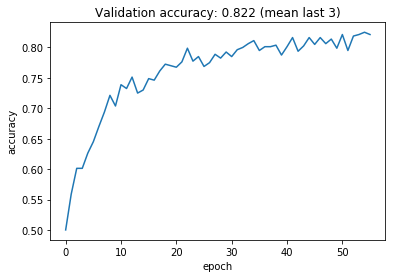

In [10]:
# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Q:** **Plot the trained weights** of the kernels from the first convolutional layer.

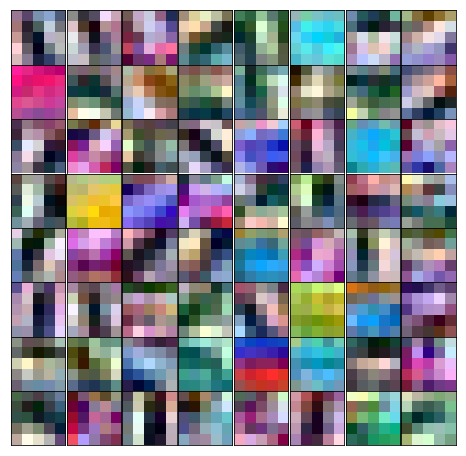

In [11]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()

In [12]:
# Put k-NN accuracy in a DataFrame to be saved for FINAL COMPARISON step
cnn_df = pd.DataFrame({'model' : ['cnn'], 'test accuracy' : [test_acc]})
cnn_df.to_csv('cnn.csv')